# 🎥 Video Tank Detection - Model Testing

This notebook processes MP4 videos to detect tank types by extracting frames and running inference.

**Tank Types:**
- `damaged_bottle`: Damaged gas tank
- `dirty_bottle`: Dirty gas tank  
- `notprimagass_bottle`: Non-Primagas tank
- `ok_bottle`: Good/acceptable tank

In [1]:
# Install required packages for video processing
import subprocess
import sys

try:
    import cv2
    print("✅ OpenCV already installed")
except ImportError:
    print("📦 Installing OpenCV for video processing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python"])
    import cv2
    print("✅ OpenCV installed successfully")

# Import other necessary libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

print("PyTorch version:", torch.__version__)
print("OpenCV version:", cv2.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

📦 Installing OpenCV for video processing...
✅ OpenCV installed successfully
PyTorch version: 2.6.0+cu124
OpenCV version: 4.12.0
CUDA available: True
GPU name: NVIDIA GeForce RTX 4060 Ti
Using device: cuda


In [2]:
# Define the same model architecture as in training
class ConvNeXtClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeXtClassifier, self).__init__()

        self.backbone = models.convnext_base(weights='DEFAULT')
        
        # Get the correct input features for the classifier
        # ConvNeXt uses a different structure than ResNet
        if hasattr(self.backbone, 'classifier'):
            # For ConvNeXt, the classifier is a Sequential with LayerNorm and Linear
            if isinstance(self.backbone.classifier, nn.Sequential):
                # Find the Linear layer in the classifier
                for module in self.backbone.classifier.modules():
                    if isinstance(module, nn.Linear):
                        in_features = module.in_features
                        break
            else:
                in_features = self.backbone.classifier.in_features
        else:
            # Fallback - this shouldn't happen with ConvNeXt
            in_features = 1024
        
        # Replace the classifier with our custom one
        # Need to add a Flatten layer before LayerNorm since ConvNeXt outputs 4D tensor
        self.backbone.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Ensure spatial dimensions are (1,1)
            nn.Flatten(),  # Flatten from [B, C, 1, 1] to [B, C]
            nn.LayerNorm(in_features, eps=1e-6),
            nn.Linear(in_features, num_classes)
        )
        
        print(f"Using ConvNeXt-Base model with {in_features} input features")
    
    def forward(self, x):
        return self.backbone(x)

# Load the trained model with PyTorch 2.6 compatibility
def load_trained_model(model_path, device='cuda'):
    """Load the trained model for inference"""
    print(f"Loading model from: {model_path}")
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    # Handle PyTorch 2.6 weights_only security change
    try:
        # Try secure loading first
        checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    except Exception as e:
        print(f"⚠️ Secure loading failed: {e}")
        print("🔓 Using weights_only=False (ensure you trust this model file)")
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Recreate model architecture
    num_classes = checkpoint['num_classes']
    model = ConvNeXtClassifier(num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✅ Model loaded successfully!")
    print(f"Architecture: {checkpoint['model_architecture']}")
    print(f"Classes: {checkpoint['class_names']}")
    print(f"Training accuracy: {checkpoint['final_accuracy']:.4f}")
    
    return model, checkpoint['class_names']

# Load your trained model
model_path = "trained_convnext_classifier.pth"
model, class_names = load_trained_model(model_path, device)

print(f"\n🚀 Ready to classify tank types: {class_names}")

Loading model from: trained_convnext_classifier.pth
⚠️ Secure loading failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to

In [3]:
# Define image preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

def preprocess_frame(frame):
    """Preprocess a video frame for inference"""
    # Convert BGR (OpenCV) to RGB (PIL)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension
    return pil_image, image_tensor

def predict_tank_type(model, image_tensor, class_names, device):
    """Predict tank type for a single frame"""
    model.eval()
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        predicted_class_idx = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class_idx].item()
        
    predicted_class = class_names[predicted_class_idx]
    
    return predicted_class, confidence, probabilities.cpu().numpy()

print("✅ Video frame preprocessing functions ready!")

✅ Video frame preprocessing functions ready!


In [4]:
# Video processing functions
def extract_frames_from_video(video_path, max_frames=30, frame_interval=None):
    """Extract frames from video for analysis"""
    print(f"📹 Processing video: {video_path}")
    
    # Open video
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps if fps > 0 else 0
    
    print(f"📊 Video info: {total_frames} frames, {fps:.2f} FPS, {duration:.2f}s duration")
    
    # Calculate frame interval if not provided
    if frame_interval is None:
        frame_interval = max(1, total_frames // max_frames)
    
    frames = []
    frame_numbers = []
    timestamps = []
    
    frame_count = 0
    extracted_count = 0
    
    while cap.isOpened() and extracted_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Extract frame at intervals
        if frame_count % frame_interval == 0:
            frames.append(frame)
            frame_numbers.append(frame_count)
            timestamps.append(frame_count / fps if fps > 0 else 0)
            extracted_count += 1
        
        frame_count += 1
    
    cap.release()
    
    print(f"✅ Extracted {len(frames)} frames from video")
    return frames, frame_numbers, timestamps

def analyze_video(video_path, model, class_names, device, max_frames=30, confidence_threshold=0.5):
    """Analyze entire video for tank detection"""
    print(f"\n🎬 ANALYZING VIDEO: {Path(video_path).name}")
    print("=" * 60)
    
    try:
        # Extract frames
        frames, frame_numbers, timestamps = extract_frames_from_video(video_path, max_frames)
        
        if not frames:
            print("❌ No frames extracted from video")
            return None
        
        # Analyze each frame
        results = []
        class_counts = {class_name: 0 for class_name in class_names}
        high_confidence_detections = []
        
        print(f"\n🔍 Analyzing {len(frames)} frames...")
        
        for i, (frame, frame_num, timestamp) in enumerate(zip(frames, frame_numbers, timestamps)):
            # Preprocess frame
            pil_image, image_tensor = preprocess_frame(frame)
            
            # Make prediction
            predicted_class, confidence, all_probabilities = predict_tank_type(
                model, image_tensor, class_names, device
            )
            
            # Store result
            result = {
                'frame_index': i,
                'frame_number': frame_num,
                'timestamp': timestamp,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'probabilities': all_probabilities,
                'frame_image': pil_image
            }
            results.append(result)
            
            # Count predictions
            class_counts[predicted_class] += 1
            
            # Track high-confidence detections
            if confidence >= confidence_threshold:
                high_confidence_detections.append(result)
            
            # Progress update
            if (i + 1) % 5 == 0 or i == len(frames) - 1:
                print(f"  Processed {i + 1}/{len(frames)} frames...")
        
        return {
            'video_path': video_path,
            'total_frames_analyzed': len(frames),
            'results': results,
            'class_counts': class_counts,
            'high_confidence_detections': high_confidence_detections,
            'confidence_threshold': confidence_threshold
        }
        
    except Exception as e:
        print(f"❌ Error analyzing video: {str(e)}")
        return None

print("✅ Video analysis functions ready!")

✅ Video analysis functions ready!


In [5]:
# Visualization functions
def plot_video_analysis_summary(analysis_result):
    """Plot summary of video analysis results"""
    if not analysis_result:
        print("❌ No analysis results to plot")
        return
    
    video_name = Path(analysis_result['video_path']).name
    class_counts = analysis_result['class_counts']
    results = analysis_result['results']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Video Analysis: {video_name}', fontsize=16, fontweight='bold')
    
    # 1. Class distribution pie chart
    ax1.pie(class_counts.values(), labels=[name.replace('_bottle', '') for name in class_counts.keys()], 
            autopct='%1.1f%%', startangle=90)
    ax1.set_title('Tank Type Distribution')
    
    # 2. Confidence over time
    timestamps = [r['timestamp'] for r in results]
    confidences = [r['confidence'] for r in results]
    ax2.plot(timestamps, confidences, 'b-', marker='o', markersize=3)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Prediction Confidence')
    ax2.set_title('Confidence Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=analysis_result['confidence_threshold'], color='r', linestyle='--', 
                label=f"Threshold ({analysis_result['confidence_threshold']})")
    ax2.legend()
    
    # 3. Class counts bar chart
    bars = ax3.bar(range(len(class_counts)), list(class_counts.values()))
    ax3.set_xlabel('Tank Types')
    ax3.set_ylabel('Number of Detections')
    ax3.set_title('Detection Counts by Class')
    ax3.set_xticks(range(len(class_counts)))
    ax3.set_xticklabels([name.replace('_bottle', '') for name in class_counts.keys()], rotation=45)
    
    # Add count labels on bars
    for bar, count in zip(bars, class_counts.values()):
        if count > 0:
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    str(count), ha='center', va='bottom')
    
    # 4. Timeline with predictions
    class_colors = {'ok_bottle': 'green', 'damaged_bottle': 'red', 
                   'dirty_bottle': 'orange', 'notprimagas_bottle': 'purple'}
    
    for result in results:
        color = class_colors.get(result['predicted_class'], 'gray')
        ax4.scatter(result['timestamp'], result['frame_index'], 
                   c=color, s=50, alpha=0.7)
    
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Frame Index')
    ax4.set_title('Predictions Timeline')
    ax4.grid(True, alpha=0.3)
    
    # Add legend for timeline
    legend_elements = [plt.scatter([], [], c=color, s=50, label=name.replace('_bottle', '')) 
                      for name, color in class_colors.items() if name in class_counts and class_counts[name] > 0]
    ax4.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()

def show_high_confidence_detections(analysis_result, max_show=6):
    """Show frames with high-confidence detections"""
    if not analysis_result or not analysis_result['high_confidence_detections']:
        print("❌ No high-confidence detections to show")
        return
    
    detections = analysis_result['high_confidence_detections'][:max_show]
    video_name = Path(analysis_result['video_path']).name
    
    print(f"\n🎯 HIGH CONFIDENCE DETECTIONS ({len(detections)} shown):")
    print("=" * 60)
    
    cols = min(3, len(detections))
    rows = (len(detections) + cols - 1) // cols
    
    plt.figure(figsize=(5 * cols, 4 * rows))
    
    for i, detection in enumerate(detections):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(detection['frame_image'])
        
        title = f"t={detection['timestamp']:.1f}s\n{detection['predicted_class'].replace('_bottle', '')}\nConf: {detection['confidence']:.3f}"
        
        # Color based on prediction
        color = 'green' if detection['predicted_class'] == 'ok_bottle' else 'red' if 'damaged' in detection['predicted_class'] else 'orange'
        plt.title(title, color=color, fontweight='bold')
        plt.axis('off')
    
    plt.suptitle(f'High Confidence Detections: {video_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✅ Visualization functions ready!")

✅ Visualization functions ready!


In [6]:
# Real-time video player with live tank detection
import threading
import time
from IPython.display import display, clear_output

def play_video_with_detection(video_path, model, class_names, device, skip_frames=1, confidence_threshold=0.6):
    """Real-time video player with live tank detection overlays"""
    print(f"🎬 REAL-TIME TANK DETECTION")
    print(f"📹 Video: {Path(video_path).name}")
    print("=" * 60)
    
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"❌ Could not open video")
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0
    
    print(f"⚡ Playing at {fps:.1f} FPS (skipping {skip_frames} frames for speed)")
    print(f"📊 Total: {total_frames} frames, {duration:.1f}s duration")
    print("🛑 Interrupt the cell to stop playback\n")
    
    frame_count = 0
    detection_count = 0
    class_counts = {name: 0 for name in class_names}
    
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Skip frames for performance
            if frame_count % (skip_frames + 1) != 0:
                frame_count += 1
                continue
            
            # Run detection
            pil_image, image_tensor = preprocess_frame(frame)
            predicted_class, confidence, _ = predict_tank_type(model, image_tensor, class_names, device)
            
            # Update statistics
            detection_count += 1
            class_counts[predicted_class] += 1
            
            # Create display frame
            display_frame = frame.copy()
            height, width = frame.shape[:2]
            
            # Status colors and messages
            if predicted_class == 'ok_bottle':
                color = (0, 255, 0)  # Green
                status = "✅ ACCEPT"
            elif 'damaged' in predicted_class:
                color = (0, 0, 255)  # Red  
                status = "❌ REJECT (DAMAGED)"
            elif 'notprimagas' in predicted_class:
                color = (255, 0, 255)  # Purple
                status = "❌ REJECT (NOT PRIMAGAS)"
            else:  # dirty
                color = (0, 165, 255)  # Orange
                status = "⚠️ NEEDS CLEANING"
            
            # Draw semi-transparent overlay box
            overlay = display_frame.copy()
            cv2.rectangle(overlay, (10, height-80), (width-10, height-10), (0, 0, 0), -1)
            cv2.addWeighted(overlay, 0.8, display_frame, 0.2, 0, display_frame)
            
            # Add text overlays
            timestamp = frame_count / fps if fps > 0 else 0
            cv2.putText(display_frame, f"{status} ({confidence:.2f})", 
                       (20, height-50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 2)
            cv2.putText(display_frame, f"Time: {timestamp:.1f}s | Frame: {frame_count}", 
                       (20, height-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            
            # Display frame
            plt.figure(figsize=(14, 8))
            frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
            plt.imshow(frame_rgb)
            plt.axis('off')
            
            # Dynamic title color based on prediction
            title_color = 'red' if 'REJECT' in status else 'green' if 'ACCEPT' in status else 'orange'
            plt.title(f'{status} | Confidence: {confidence:.3f} | Time: {timestamp:.1f}s', 
                     fontsize=16, fontweight='bold', color=title_color)
            
            clear_output(wait=True)
            plt.show()
            
            # Brief pause for display (adjust for playback speed)
            time.sleep(0.1)
            
            frame_count += 1
            
    except KeyboardInterrupt:
        print("\n⏹️ Playback stopped by user")
    finally:
        cap.release()
        plt.close('all')
        
        # Show final summary
        print(f"\n📊 REAL-TIME ANALYSIS SUMMARY:")
        print(f"Frames processed: {detection_count}")
        if detection_count > 0:
            print("Detection counts:")
            for class_name, count in class_counts.items():
                if count > 0:
                    percentage = (count / detection_count) * 100
                    status_icon = "✅" if class_name == 'ok_bottle' else "❌" if 'damaged' in class_name or 'notprimagas' in class_name else "⚠️"
                    print(f"  {status_icon} {class_name}: {count} ({percentage:.1f}%)")

print("🎮 Real-time video player function ready!")

🎮 Real-time video player function ready!


In [7]:
# Video saving function with tank detection overlays
def save_video_with_detection(input_video_path, output_video_path, model, class_names, device, 
                              confidence_threshold=0.6, show_progress=True):
    """Save a video with tank detection overlays and annotations"""
    print(f"🎥 SAVING VIDEO WITH DETECTIONS")
    print(f"📹 Input: {Path(input_video_path).name}")
    print(f"💾 Output: {output_video_path}")
    print("=" * 60)
    
    # Open input video
    cap = cv2.VideoCapture(str(input_video_path))
    if not cap.isOpened():
        print(f"❌ Could not open input video")
        return None
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0
    
    print(f"📊 Video properties: {width}x{height}, {fps:.1f} FPS, {total_frames} frames, {duration:.1f}s")
    
    # Define the codec and create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can also try 'XVID'
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    if not out.isOpened():
        print("❌ Could not open output video writer")
        cap.release()
        return None
    
    frame_count = 0
    detection_stats = {name: 0 for name in class_names}
    high_confidence_count = 0
    
    print(f"🚀 Processing {total_frames} frames...")
    
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Run detection on frame
            pil_image, image_tensor = preprocess_frame(frame)
            predicted_class, confidence, _ = predict_tank_type(model, image_tensor, class_names, device)
            
            # Update statistics
            detection_stats[predicted_class] += 1
            if confidence >= confidence_threshold:
                high_confidence_count += 1
            
            # Create annotated frame
            annotated_frame = frame.copy()
            
            # Status colors and messages
            if predicted_class == 'ok_bottle':
                color = (0, 255, 0)  # Green
                status = "✅ ACCEPT"
                bg_color = (0, 100, 0)  # Dark green background
            elif 'damaged' in predicted_class:
                color = (0, 0, 255)  # Red  
                status = "❌ REJECT (DAMAGED)"
                bg_color = (0, 0, 100)  # Dark red background
            elif 'notprimagas' in predicted_class:
                color = (255, 0, 255)  # Purple
                status = "❌ REJECT (NOT PRIMAGAS)"
                bg_color = (100, 0, 100)  # Dark purple background
            else:  # dirty
                color = (0, 165, 255)  # Orange
                status = "⚠️ NEEDS CLEANING"
                bg_color = (0, 80, 100)  # Dark orange background
            
            # Draw semi-transparent background box for text
            overlay = annotated_frame.copy()
            cv2.rectangle(overlay, (10, height-100), (width-10, height-10), bg_color, -1)
            cv2.addWeighted(overlay, 0.7, annotated_frame, 0.3, 0, annotated_frame)
            
            # Add main status text
            timestamp = frame_count / fps if fps > 0 else 0
            cv2.putText(annotated_frame, f"{status}", 
                       (20, height-70), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)
            cv2.putText(annotated_frame, f"Confidence: {confidence:.3f}", 
                       (20, height-45), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            cv2.putText(annotated_frame, f"Time: {timestamp:.1f}s | Frame: {frame_count+1}/{total_frames}", 
                       (20, height-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            
            # Add confidence indicator (progress bar style)
            bar_width = 200
            bar_height = 10
            bar_x = width - bar_width - 20
            bar_y = height - 80
            
            # Background bar
            cv2.rectangle(annotated_frame, (bar_x, bar_y), (bar_x + bar_width, bar_y + bar_height), (50, 50, 50), -1)
            # Confidence bar
            conf_width = int(bar_width * confidence)
            conf_color = color if confidence >= confidence_threshold else (100, 100, 100)
            cv2.rectangle(annotated_frame, (bar_x, bar_y), (bar_x + conf_width, bar_y + bar_height), conf_color, -1)
            
            # Add threshold line
            thresh_x = bar_x + int(bar_width * confidence_threshold)
            cv2.line(annotated_frame, (thresh_x, bar_y-5), (thresh_x, bar_y + bar_height + 5), (255, 255, 255), 2)
            
            # Write frame to output video
            out.write(annotated_frame)
            
            frame_count += 1
            
            # Show progress
            if show_progress and (frame_count % 30 == 0 or frame_count == total_frames):
                progress = (frame_count / total_frames) * 100
                print(f"  Progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")
    
    except Exception as e:
        print(f"❌ Error during video processing: {str(e)}")
        return None
    
    finally:
        # Clean up
        cap.release()
        out.release()

    print(f"\n📈 Detection Statistics:")
    for class_name, count in detection_stats.items():
        if count > 0:
            percentage = (count / frame_count) * 100
            status_icon = "✅" if class_name == 'ok_bottle' else "❌" if 'damaged' in class_name or 'notprimagas' in class_name else "⚠️"
            print(f"  {status_icon} {class_name}: {count} frames ({percentage:.1f}%)")
    
    return {
        'output_path': output_video_path,
        'total_frames': frame_count,
        'detection_stats': detection_stats,
        'high_confidence_count': high_confidence_count,
        'fps': fps,
        'duration': duration
    }



In [10]:
input_video = r"C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\gass_GASSY\ConvNext - Classifier\input\14_43_back_right_cropped.mp4"
output_video = r"C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\gass_GASSY\ConvNext - Classifier\output\back_right_detected.mp4"

# Save the processed video
result = save_video_with_detection(
    input_video_path=input_video,
    output_video_path=output_video,
    model=model,
    class_names=class_names,
    device=device,
    confidence_threshold=0.6,
    show_progress=True
)


🎥 SAVING VIDEO WITH DETECTIONS
📹 Input: 14_43_back_right_cropped.mp4
💾 Output: C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\gass_GASSY\ConvNext - Classifier\output\back_right_detected.mp4
📊 Video properties: 2704x1520, 23.0 FPS, 16956 frames, 737.2s
🚀 Processing 16956 frames...
  Progress: 30/16956 frames (0.2%)
  Progress: 60/16956 frames (0.4%)
  Progress: 90/16956 frames (0.5%)
  Progress: 120/16956 frames (0.7%)
  Progress: 150/16956 frames (0.9%)
  Progress: 180/16956 frames (1.1%)
  Progress: 210/16956 frames (1.2%)
  Progress: 240/16956 frames (1.4%)
  Progress: 270/16956 frames (1.6%)
  Progress: 300/16956 frames (1.8%)
  Progress: 330/16956 frames (1.9%)
  Progress: 360/16956 frames (2.1%)
  Progress: 390/16956 frames (2.3%)
  Progress: 420/16956 frames (2.5%)
  Progress: 450/16956 frames (2.7%)
  Progress: 480/16956 frames (2.8%)
  Progress: 510/16956 frames (3.0%)
  Progress: 540/16956 frames (3.2%)
  Progress: 570/16956 frames (3.4%)
  Progress: 600

In [9]:
# Call the real-time player function
play_video_with_detection(
    video_path=r"C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\gass_GASSY\ConvNext - Classifier\input\14_43_front_cropped.mp4",
    model=model,
    class_names=class_names, 
    device=device,
)


⏹️ Playback stopped by user

📊 REAL-TIME ANALYSIS SUMMARY:
Frames processed: 21
Detection counts:
  ✅ ok_bottle: 21 (100.0%)


🎬 Video paths configured:
  1. ✅ C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\test\14_43_back_left_cropped.mp4
  2. ✅ C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\test\14_43_back_right_cropped.mp4
  3. ✅ C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\test\14_43_front_cropped.mp4

🎬 ANALYZING VIDEO: 14_43_back_left_cropped.mp4
📹 Processing video: C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\test\14_43_back_left_cropped.mp4
📊 Video info: 16956 frames, 23.00 FPS, 737.22s duration
✅ Extracted 20 frames from video

🔍 Analyzing 20 frames...
  Processed 5/20 frames...
  Processed 10/20 frames...
✅ Extracted 20 frames from video

🔍 Analyzing 20 frames...
  Processed 5/20 frames...
  Processed 10/20 frames...
  Processed 15/20 frames...
  Processed 20/20 frames...

📊 SUMMARY FOR 14_43_back_left_cropped.mp4:
----------------------------------------
Total frames analyzed: 20
High confidence detection

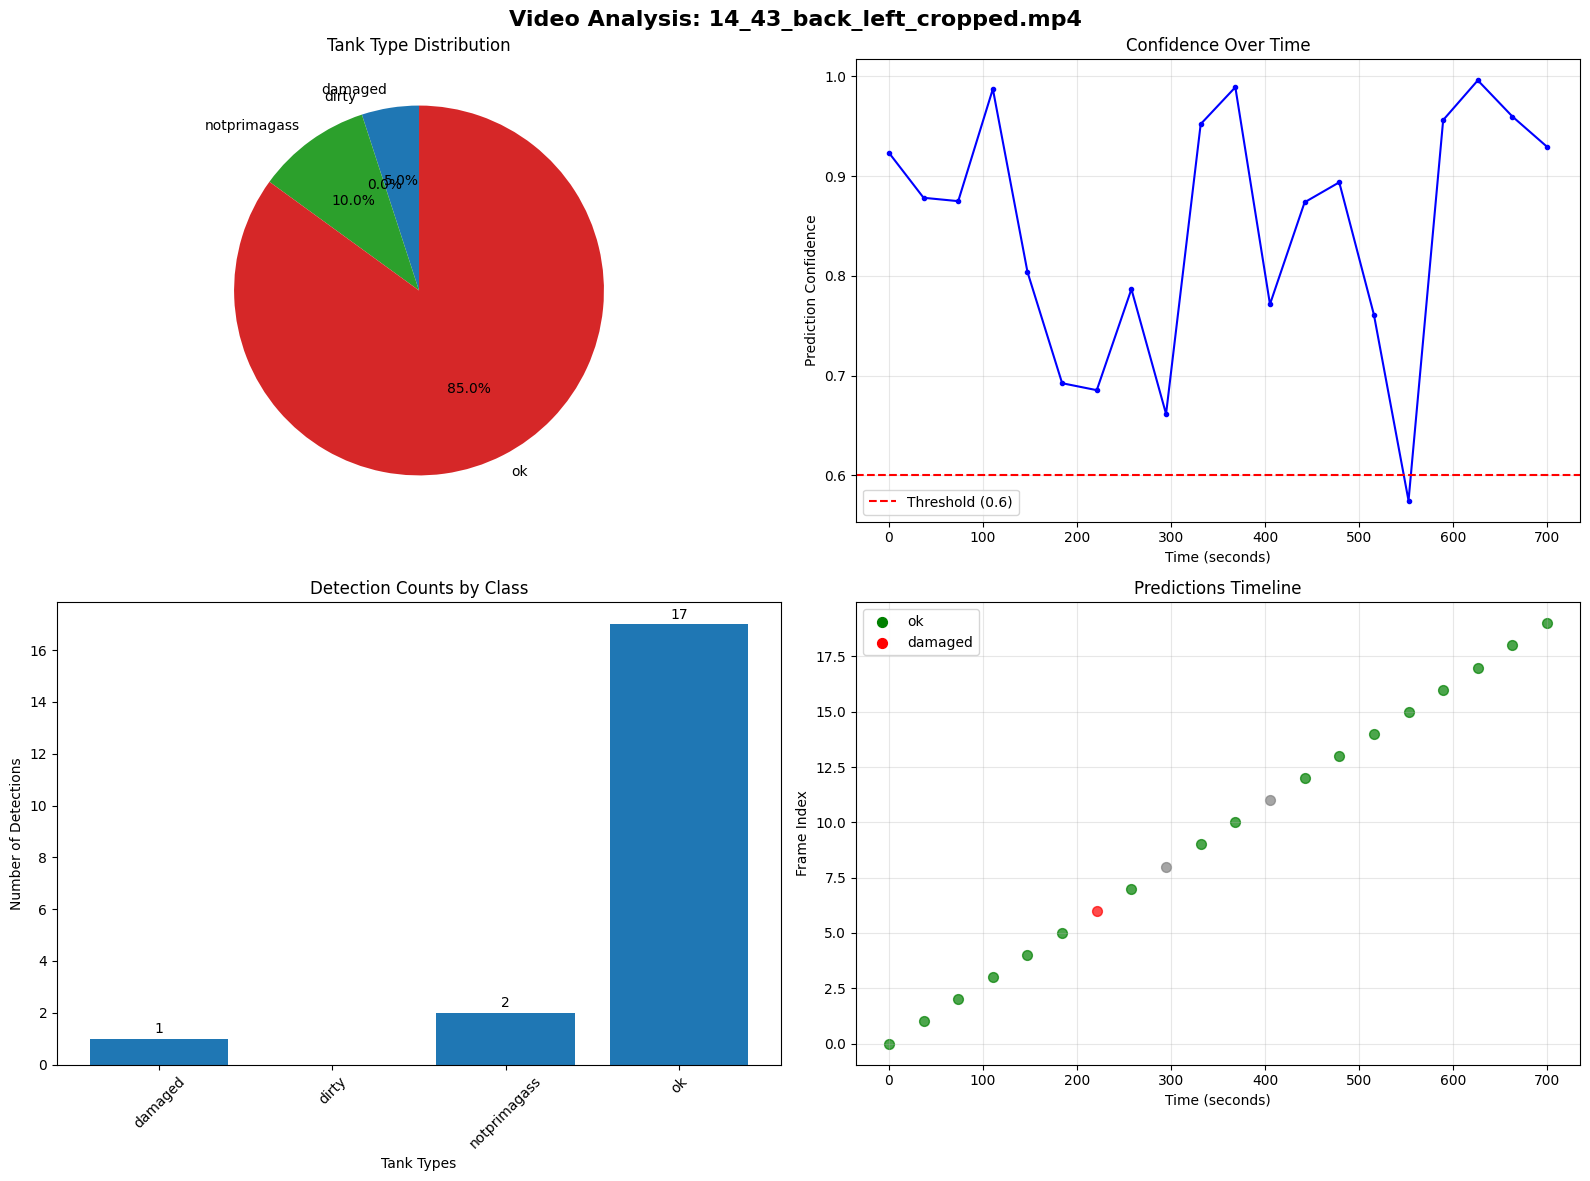


🎯 HIGH CONFIDENCE DETECTIONS (6 shown):


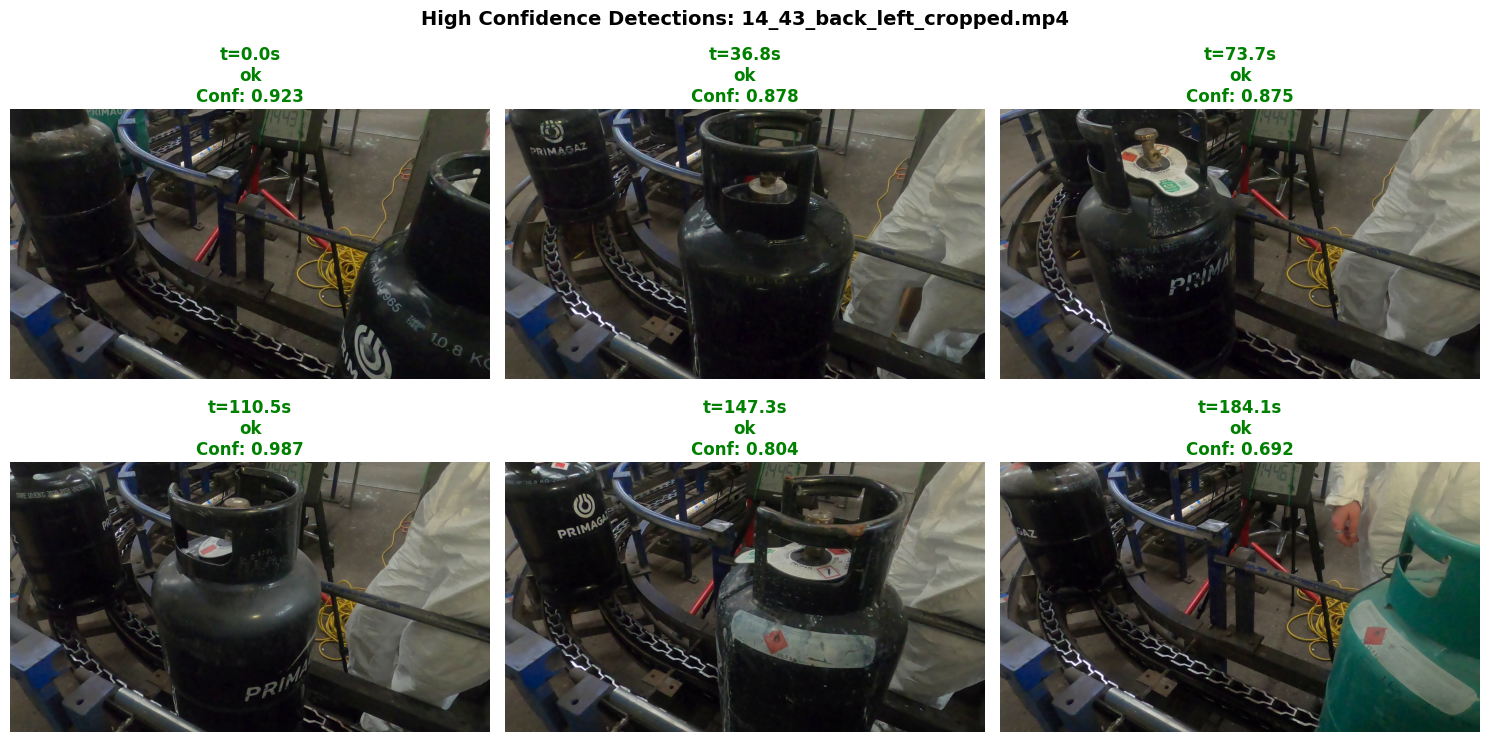




🎬 ANALYZING VIDEO: 14_43_back_right_cropped.mp4
📹 Processing video: C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\test\14_43_back_right_cropped.mp4
📊 Video info: 16956 frames, 23.00 FPS, 737.22s duration
✅ Extracted 20 frames from video

🔍 Analyzing 20 frames...
✅ Extracted 20 frames from video

🔍 Analyzing 20 frames...
  Processed 5/20 frames...
  Processed 10/20 frames...
  Processed 15/20 frames...
  Processed 5/20 frames...
  Processed 10/20 frames...
  Processed 15/20 frames...
  Processed 20/20 frames...

📊 SUMMARY FOR 14_43_back_right_cropped.mp4:
----------------------------------------
Total frames analyzed: 20
High confidence detections: 18
Class distribution:
  notprimagass_bottle: 1 frames (5.0%)
  ok_bottle: 19 frames (95.0%)
  Processed 20/20 frames...

📊 SUMMARY FOR 14_43_back_right_cropped.mp4:
----------------------------------------
Total frames analyzed: 20
High confidence detections: 18
Class distribution:
  notprimagass_bottle: 1 frames (

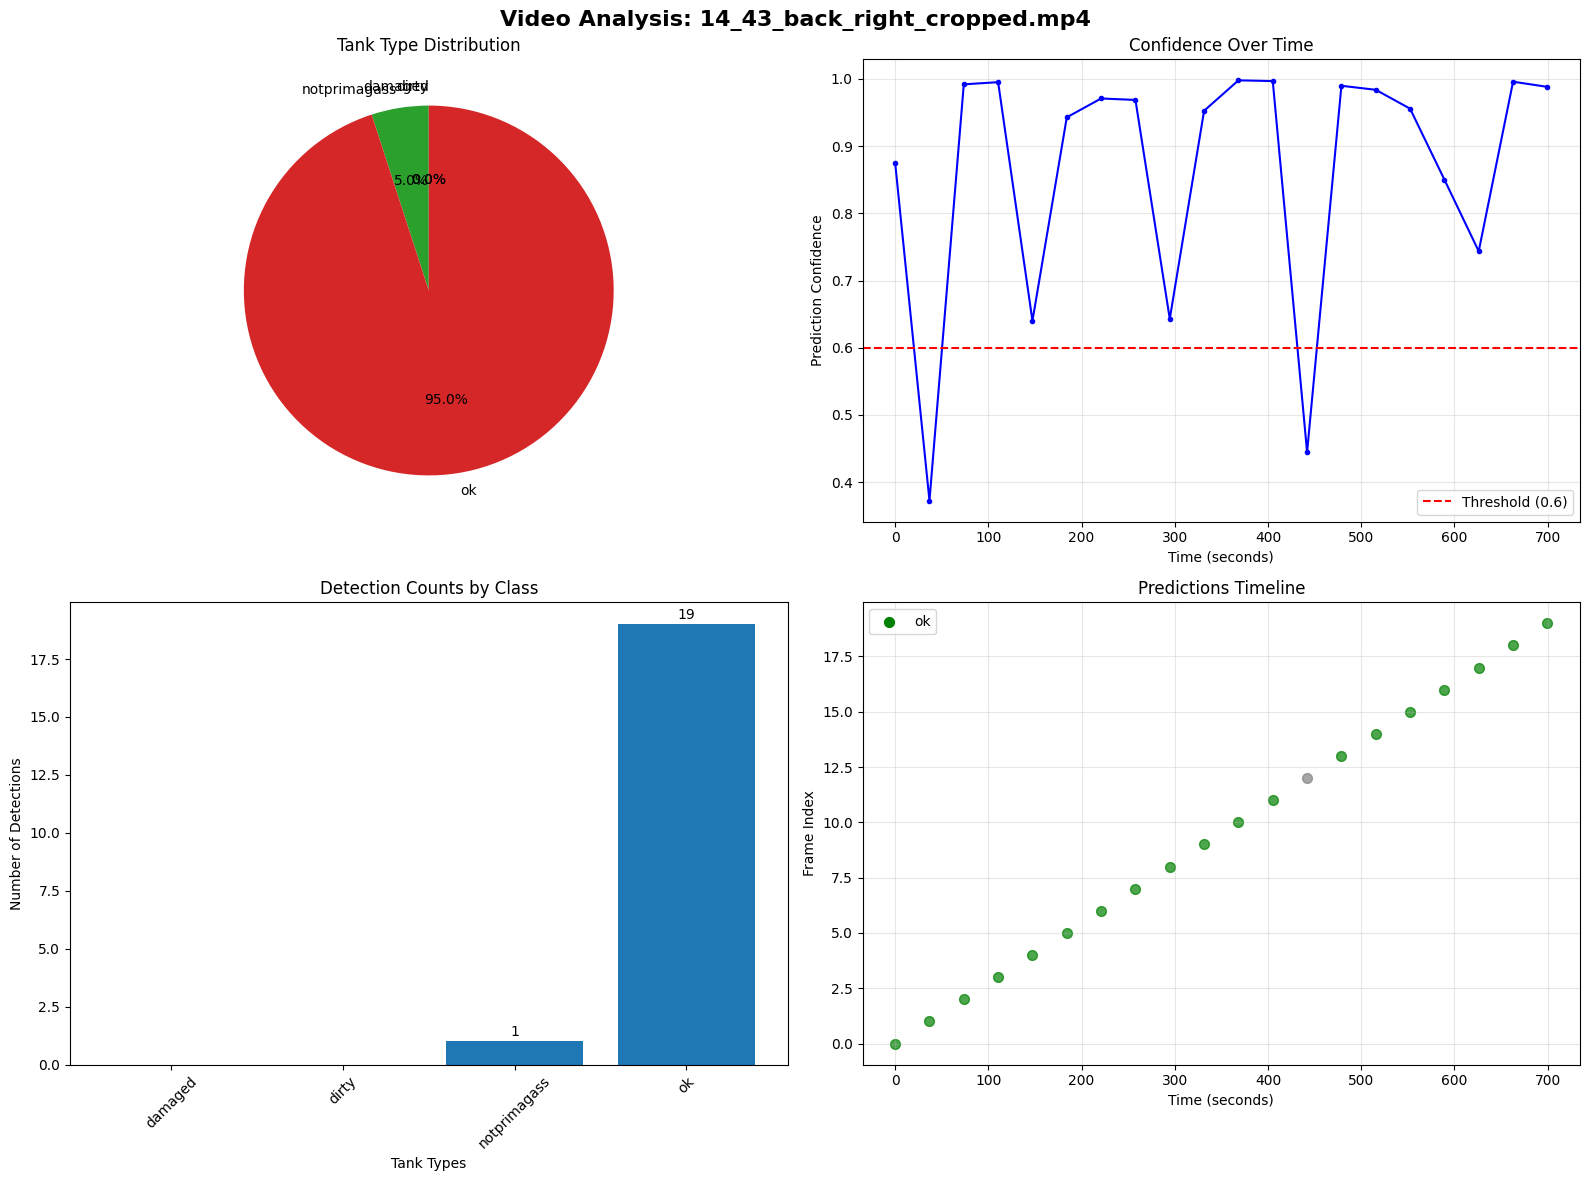


🎯 HIGH CONFIDENCE DETECTIONS (6 shown):


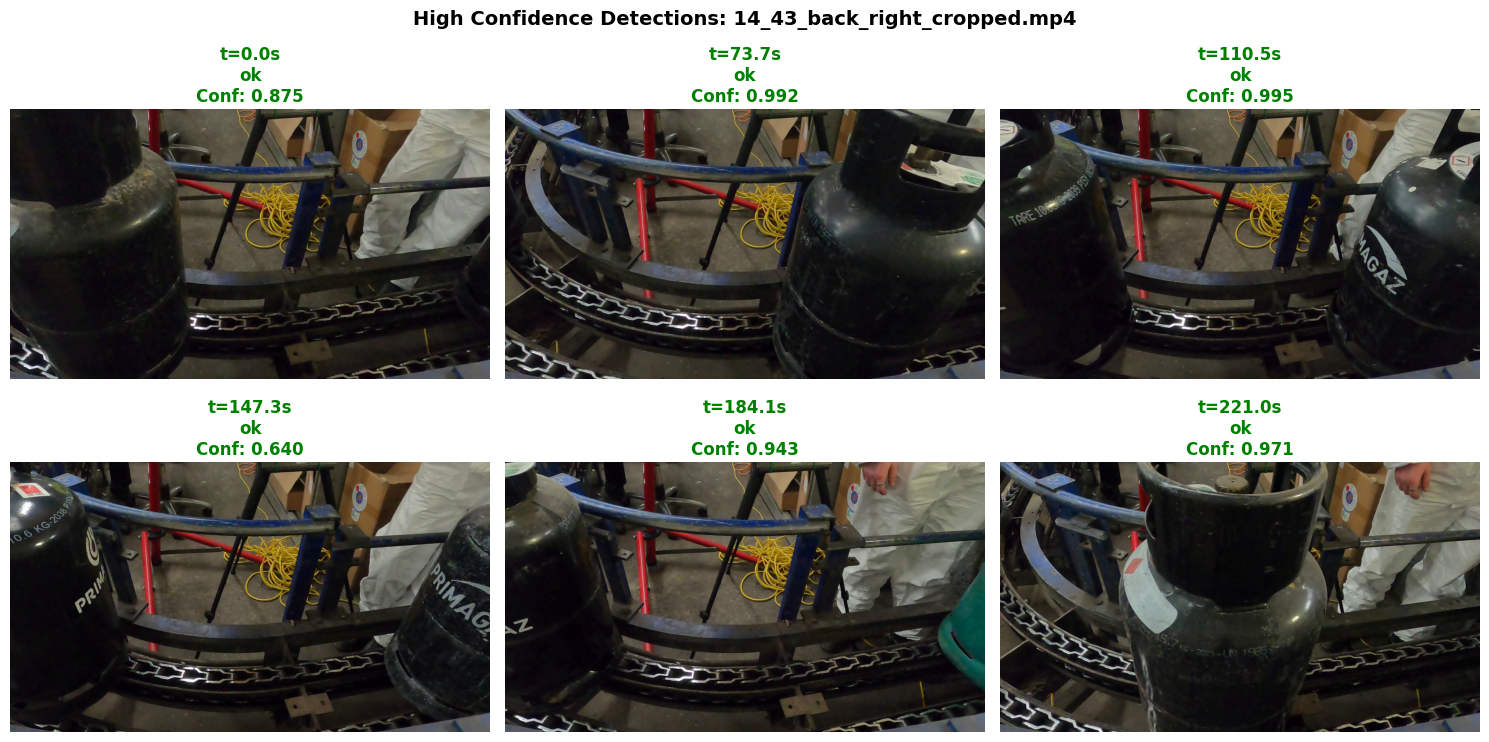




🎬 ANALYZING VIDEO: 14_43_front_cropped.mp4
📹 Processing video: C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\test\14_43_front_cropped.mp4
📊 Video info: 16956 frames, 23.00 FPS, 737.22s duration
✅ Extracted 20 frames from video

🔍 Analyzing 20 frames...
✅ Extracted 20 frames from video

🔍 Analyzing 20 frames...
  Processed 5/20 frames...
  Processed 10/20 frames...
  Processed 15/20 frames...
  Processed 5/20 frames...
  Processed 10/20 frames...
  Processed 15/20 frames...
  Processed 20/20 frames...

📊 SUMMARY FOR 14_43_front_cropped.mp4:
----------------------------------------
Total frames analyzed: 20
High confidence detections: 16
Class distribution:
  damaged_bottle: 2 frames (10.0%)
  notprimagass_bottle: 4 frames (20.0%)
  ok_bottle: 14 frames (70.0%)
  Processed 20/20 frames...

📊 SUMMARY FOR 14_43_front_cropped.mp4:
----------------------------------------
Total frames analyzed: 20
High confidence detections: 16
Class distribution:
  damaged_bottle:

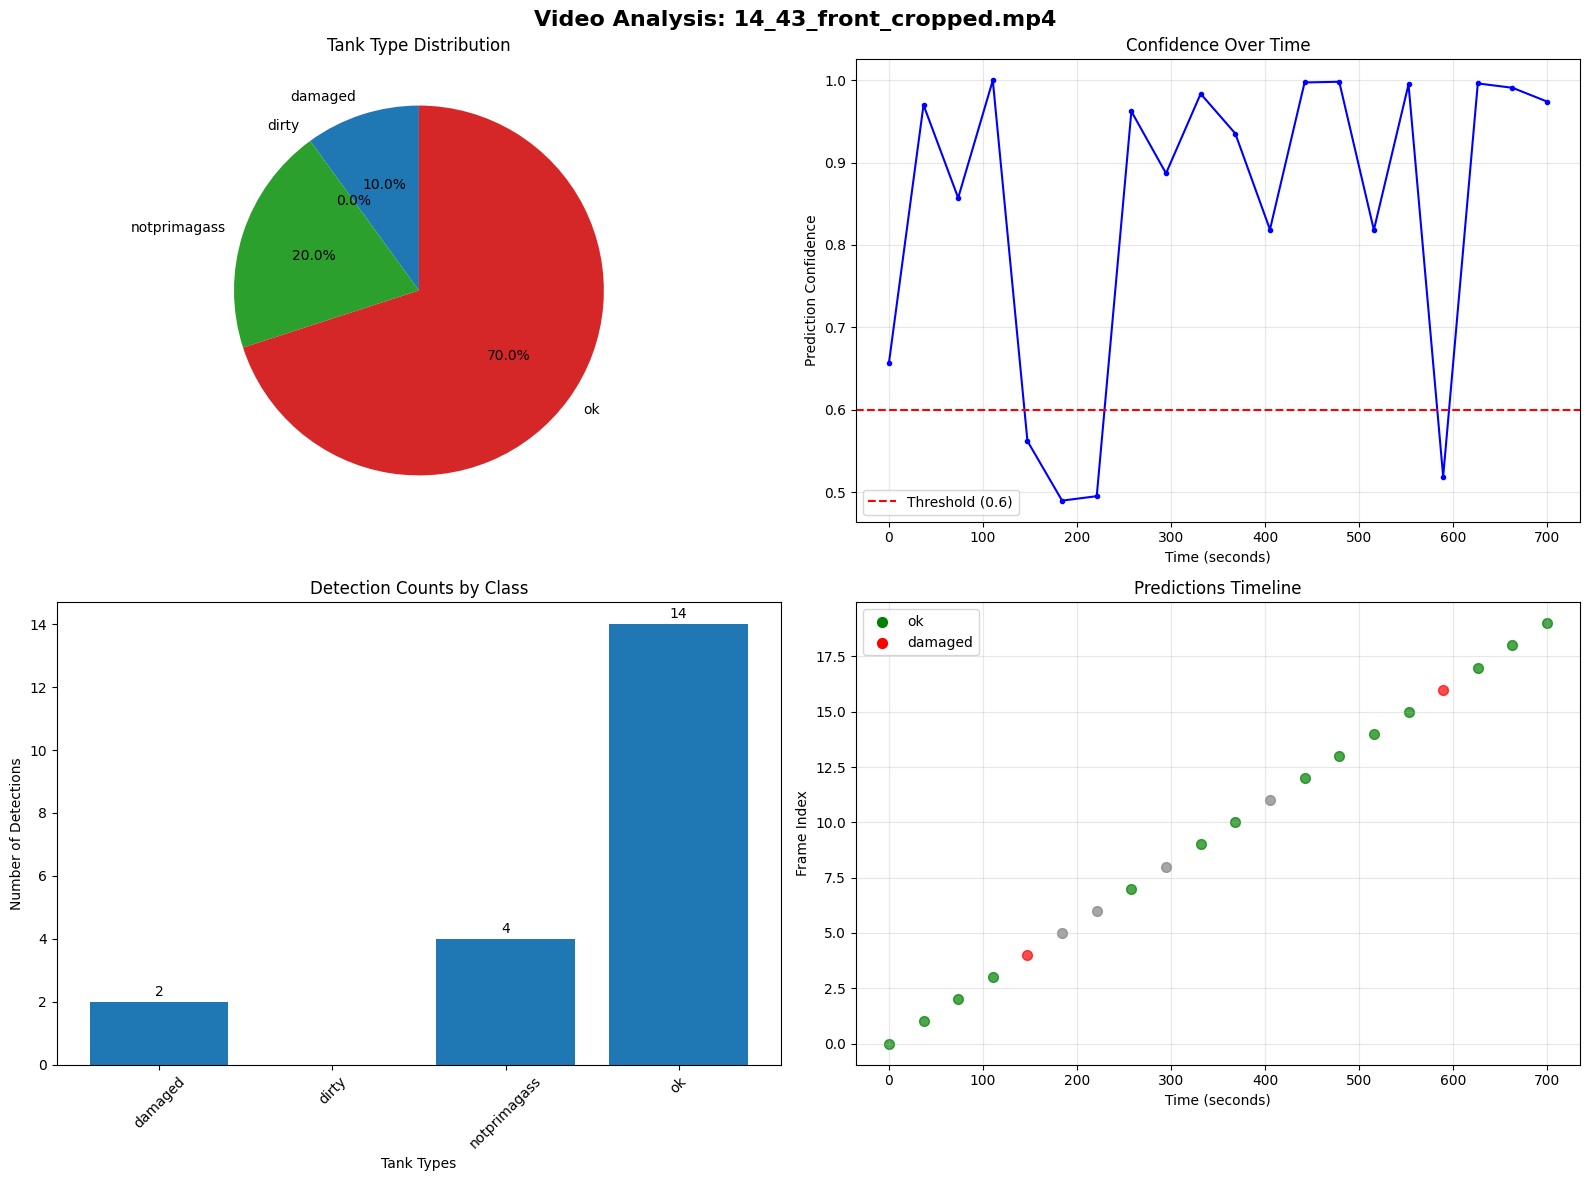


🎯 HIGH CONFIDENCE DETECTIONS (6 shown):


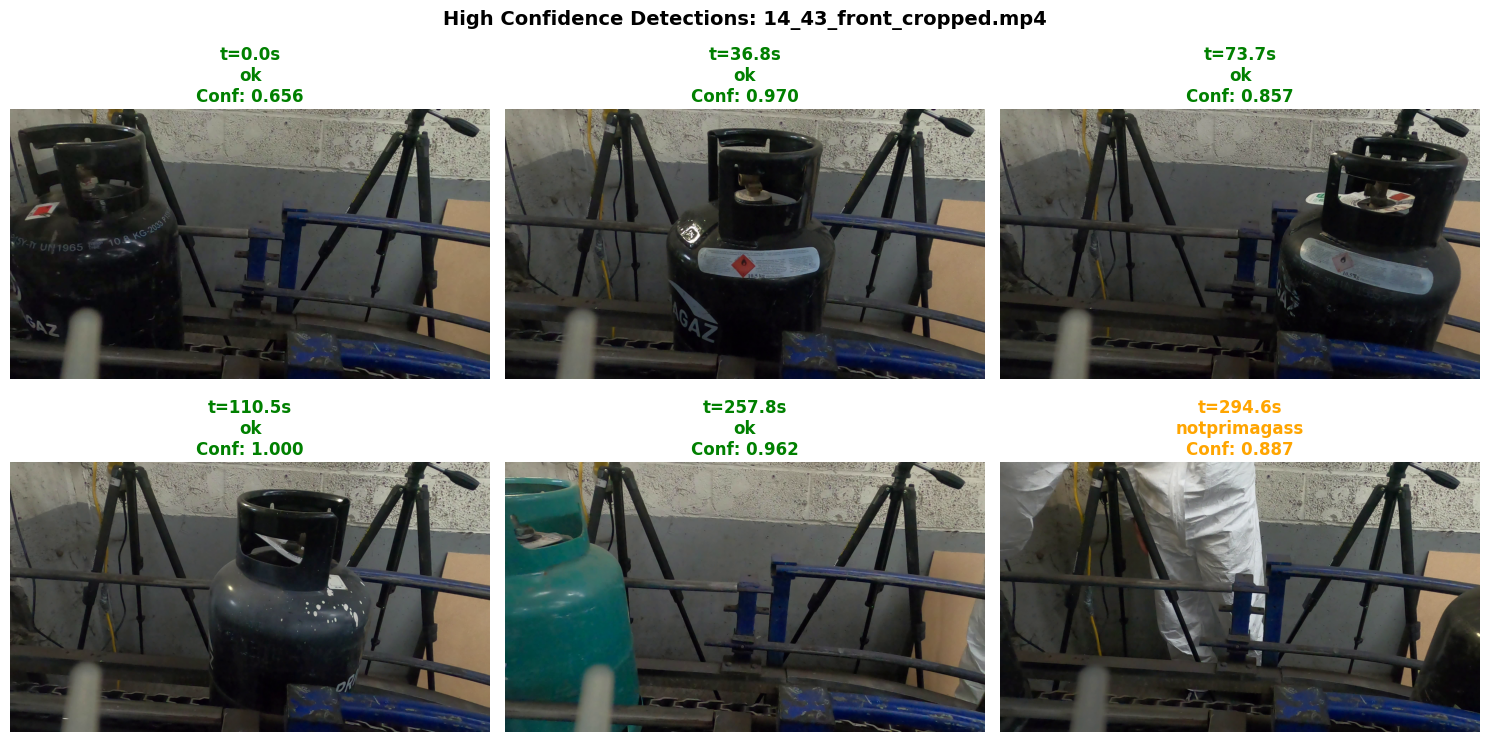




🎉 Analysis complete! Processed 3 videos.


In [14]:
# TEST YOUR 3 MP4 VIDEOS HERE
# Update these paths with your actual video file locations

video_paths = [
    r"C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\test\14_43_back_left_cropped.mp4",  # ← UPDATE THESE PATHS
    r"C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\test\14_43_back_right_cropped.mp4",  # ← UPDATE THESE PATHS  
    r"C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\test\14_43_front_cropped.mp4",  # ← UPDATE THESE PATHS
]

# Or if they're in the same folder:
# video_folder = Path(r"C:\path\to\your\videos")
# video_paths = list(video_folder.glob("*.mp4"))

print("🎬 Video paths configured:")
for i, path in enumerate(video_paths, 1):
    exists = "✅" if Path(path).exists() else "❌"
    print(f"  {i}. {exists} {path}")

# Analyze each video
all_results = []

for video_path in video_paths:
    if not Path(video_path).exists():
        print(f"\n⚠️ Skipping non-existent video: {video_path}")
        continue
    
    # Analyze video (extract 20 frames, confidence threshold 0.6)
    result = analyze_video(
        video_path=video_path,
        model=model,
        class_names=class_names,
        device=device,
        max_frames=20,  # Extract 20 frames
        confidence_threshold=0.6  # Only show detections > 60% confidence
    )
    
    if result:
        all_results.append(result)
        
        # Show summary
        print(f"\n📊 SUMMARY FOR {Path(video_path).name}:")
        print("-" * 40)
        print(f"Total frames analyzed: {result['total_frames_analyzed']}")
        print(f"High confidence detections: {len(result['high_confidence_detections'])}")
        print("Class distribution:")
        for class_name, count in result['class_counts'].items():
            if count > 0:
                percentage = (count / result['total_frames_analyzed']) * 100
                print(f"  {class_name}: {count} frames ({percentage:.1f}%)")
        
        # Plot analysis
        plot_video_analysis_summary(result)
        
        # Show high confidence detections
        show_high_confidence_detections(result, max_show=6)
        
        print("\n" + "=" * 80 + "\n")

print(f"\n🎉 Analysis complete! Processed {len(all_results)} videos.")

In [ ]:
# Generate overall summary report
if all_results:
    print("📋 OVERALL SUMMARY REPORT")
    print("=" * 50)
    
    total_frames = sum(r['total_frames_analyzed'] for r in all_results)
    total_high_conf = sum(len(r['high_confidence_detections']) for r in all_results)
    
    print(f"📊 Total videos analyzed: {len(all_results)}")
    print(f"📊 Total frames processed: {total_frames}")
    print(f"📊 High confidence detections: {total_high_conf}")
    
    # Aggregate class counts
    overall_counts = {class_name: 0 for class_name in class_names}
    for result in all_results:
        for class_name, count in result['class_counts'].items():
            overall_counts[class_name] += count
    
    print("\n🏷️ Overall tank type distribution:")
    for class_name, count in overall_counts.items():
        if count > 0:
            percentage = (count / total_frames) * 100
            status = "✅ ACCEPT" if class_name == 'ok_bottle' else "❌ REJECT" if 'damaged' in class_name or 'notprimagass' in class_name else "⚠️ CLEAN"
            print(f"  {class_name}: {count} frames ({percentage:.1f}%) → {status}")
    
    # Recommendations
    print("\n💡 RECOMMENDATIONS:")
    if overall_counts['ok_bottle'] > total_frames * 0.7:
        print("✅ Most tanks appear to be in good condition")
    elif overall_counts['damaged_bottle'] > total_frames * 0.3:
        print("⚠️ High number of damaged tanks detected - inspect carefully")
    elif overall_counts['dirty_bottle'] > total_frames * 0.3:
        print("🧽 Many tanks need cleaning")
    elif overall_counts['notprimagass_bottle'] > total_frames * 0.2:
        print("🚫 Non-Primagas tanks detected - verify supplier")
    
    # Plot overall distribution
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    valid_counts = {k: v for k, v in overall_counts.items() if v > 0}
    plt.pie(valid_counts.values(), labels=[name.replace('_bottle', '') for name in valid_counts.keys()], 
            autopct='%1.1f%%', startangle=90)
    plt.title('Overall Tank Type Distribution')
    
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(len(overall_counts)), list(overall_counts.values()))
    plt.xlabel('Tank Types')
    plt.ylabel('Total Detections')
    plt.title('Total Detection Counts')
    plt.xticks(range(len(overall_counts)), [name.replace('_bottle', '') for name in overall_counts.keys()], rotation=45)
    
    # Add count labels
    for bar, count in zip(bars, overall_counts.values()):
        if count > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No video analysis results to summarize")
    print("\nPlease:")
    print("1. Update the video_paths list with your actual MP4 file locations")
    print("2. Make sure the video files exist")
    print("3. Re-run the analysis cell")

# 🎬 How to Use This Video Analysis

## Quick Start:
1. **Update video paths** in the analysis cell above
2. **Run all cells** to analyze your 3 MP4 videos
3. **Review results** - charts, high-confidence detections, and summary

## What You Get:
- **Frame-by-frame analysis** of tank types
- **Confidence scores** for each detection
- **Visual timeline** showing detections over time
- **High-confidence highlights** showing best detections
- **Overall summary** across all videos

## Tank Classifications:
- **✅ ok_bottle**: Tank is acceptable for use
- **❌ damaged_bottle**: Tank is damaged, reject
- **⚠️ dirty_bottle**: Tank needs cleaning
- **❌ notprimagass_bottle**: Not a Primagas tank, reject

## Settings You Can Adjust:
- **max_frames**: Number of frames to extract (default: 20)
- **confidence_threshold**: Minimum confidence to highlight (default: 0.6)
- **frame_interval**: How often to sample frames (auto-calculated)

Your RTX 4060 Ti will accelerate the analysis for fast processing! 🚀